# Conformance checking in python

In [1]:
import pandas as pd
import re
import json
from scipy import stats
import matplotlib.pyplot as plt

### Load pre-requisites data

In [2]:
# Load the JSON file into a Python dictionary
with open('../../data/course_prerequisites.json', 'r', encoding='utf-8') as f:
    course_prerequisites = json.load(f)

### Functions for pre-requisite checking and student traces

In [3]:
def check_prerequisites(course_code, passed_courses, course_prerequisites):
    # Get the prerequisites expression for the course
    prerequisites = course_prerequisites.get(course_code, '')

    # If there are no prerequisites, return True and 0 "OR" conditions
    if not prerequisites:
        return True, 0

    # Replace course numbers with True/False based on passed courses
    def replace_course_with_boolean(match):
        course = match.group(0)
        return str(course in passed_courses)

    prerequisites = re.sub(r'\d{4,5}', replace_course_with_boolean, prerequisites)
    # print(f"Processed prerequisites for {course_code}: {prerequisites}")

    # Count "OR" conditions in the expression
    or_count = prerequisites.count(' or ')

    # Evaluate the expression
    try:
        result = eval(prerequisites)
        # Count only if multiple "OR" conditions are satisfied
        if result and or_count > 1:
            return result, or_count
        else:
            return result, 0
    except Exception as e:
        print(f"Error evaluating prerequisites for {course_code}: {e}")
        return False, 0

def evaluate_course_sequence(course_sequence, course_prerequisites):
    fulfilled_courses = []
    not_fulfilled_courses = []
    passed_courses = set()
    multiple_or_reqs = 0

    for course in course_sequence:
        # Check if prerequisites are met and count "OR" conditions
        is_fulfilled, or_count = check_prerequisites(course, passed_courses, course_prerequisites)

        # Increment the count only if the course has multiple "OR" conditions that are satisfied
        if is_fulfilled and or_count > 1:
            multiple_or_reqs += 1

        # Add the course to passed_courses whether or not it initially passes the prerequisites
        passed_courses.add(course)

        if is_fulfilled:
            fulfilled_courses.append(course)
        else:
            not_fulfilled_courses.append(course)

    return fulfilled_courses, not_fulfilled_courses, multiple_or_reqs

### Create traces for each student

In [4]:
# Load the CSV file with student data
student_data_path = '../../data/cleaned_student_data.csv'
student_data = pd.read_csv(student_data_path)

# Group the data by StudentID and sort by GradeDate for each student
student_data['GradeDate'] = pd.to_datetime(student_data['GradeDate'])
ordered_course_sequences = (
    student_data.sort_values(by=['StudentID', 'GradeDate'])
    .groupby('StudentID')['CourseCode']
    .apply(list)
    .reset_index()
)

# Rename the columns for clarity
ordered_course_sequences.columns = ['StudentID', 'OrderedCourseSequence']

# Save the processed data to a new CSV file
output_path = '../../data/ordered_student_course_sequences.csv'
ordered_course_sequences.to_csv(output_path, index=False)

### Perform conformance checking on student traces

In [5]:
def analyze_student_courses(student_id, course_sequence, course_grades, course_prerequisites):
    num_with_prereqs = 0
    num_without_prereqs = 0
    multiple_or_reqs_count = 0
    passed_courses = set()
    grades = []

    for course in course_sequence:
        # Append grade if it exists for the course
        if course in course_grades and not pd.isnull(course_grades[course]):
            grades.append(course_grades[course])
        
        # Check prerequisites for the course
        is_fulfilled, or_count = check_prerequisites(course, passed_courses, course_prerequisites)
        if is_fulfilled:
            num_with_prereqs += 1
            if or_count > 1:
                multiple_or_reqs_count += 1
        else:
            num_without_prereqs += 1
            
        # Add the course to passed_courses
        passed_courses.add(course)

    # Calculate grade average (ignoring missing grades)
    grade_avg = sum(grades) / len(grades) if grades else None
    return num_with_prereqs, num_without_prereqs, multiple_or_reqs_count, grade_avg


# Precompute course grades as a dictionary for faster lookup
student_course_grades = {student_id: dict(zip(group['CourseCode'], pd.to_numeric(group['Grade'], errors='coerce'))) for student_id, group in student_data.groupby('StudentID')}
# Run the final optimized analysis on each student's course sequence
results = []

for _, row in ordered_course_sequences.iterrows():
    student_id = row['StudentID']
    course_sequence = row['OrderedCourseSequence']
    if student_id in student_course_grades:
        course_grades = student_course_grades[student_id]
        num_with_prereqs, num_without_prereqs, multiple_or_reqs_count, grade_avg = analyze_student_courses(student_id, course_sequence, course_grades, course_prerequisites)

        results.append({
            'StudentID': student_id,
            'CoursesWithPrereqsFulfilled': num_with_prereqs,
            'CoursesWithoutPrereqs': num_without_prereqs,
            'TotalMultipleORReqs': multiple_or_reqs_count,
            'GradeAverage': grade_avg
        })

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
output_results_path = '../../data/student_course_analysis.csv'
results_df.to_csv(output_results_path, index=False)

### Analyze the conformance checking results

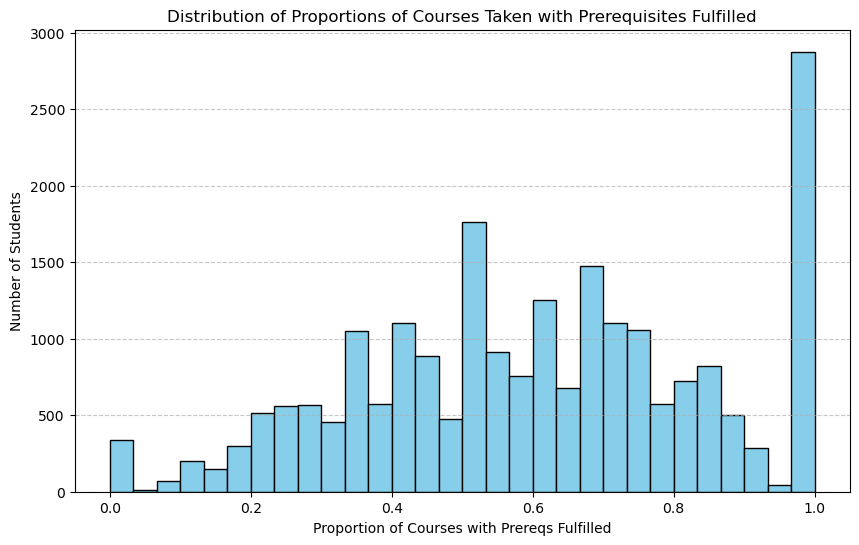

Number of students who fulfilled their prerequisites at threshold 1.0: 2877, those who did not: 19209
Mean grade for students who fulfilled their prerequisites at the 1.0 threshold: 7.74
Mean grade for students who did not fulfill their prerequisites at the 1.0 threshold: 7.48
T-statistic: 2.90, P-value: 3.76e-03
The p-value (3.76e-03) is less than the significance level (alpha = 0.05), we conclude that there is a statistically significant difference in the mean grades between the two groups.


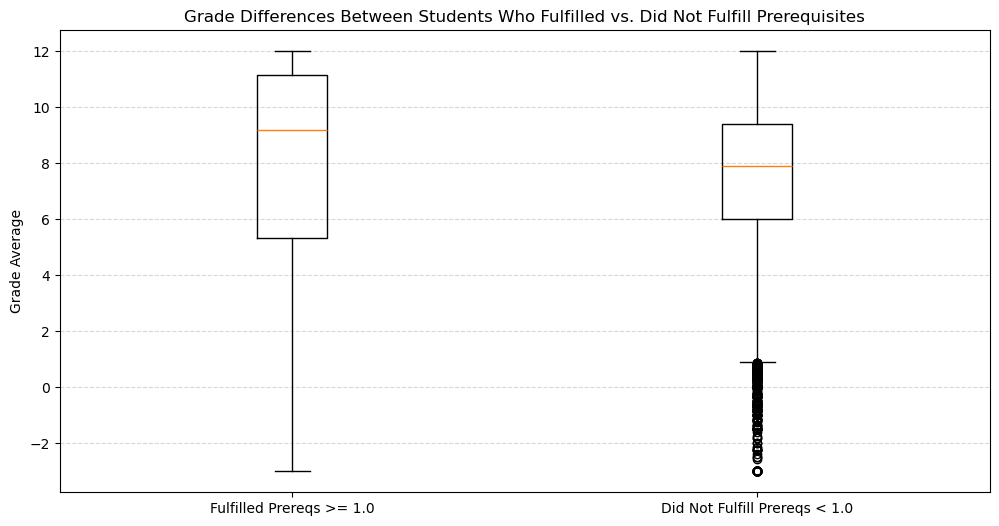

Outlier analysis: 
 {'Fulfilled Prereqs Outliers': 0, 'Did Not Fulfill Prereqs Outliers': 391, 'Max Outlier Fulfilled': nan, 'Min Outlier Fulfilled': nan, 'Max Outlier Not Fulfilled': 0.875, 'Min Outlier Not Fulfilled': -3.0}


In [6]:
# Significance level
alpha = 0.05
# Threshold for grouping students into conformant/non-conformant 
threshold = 1.0

# Load the provided analysis results file
analysis_results_path = '../../data/student_course_analysis.csv'
analysis_results_df = pd.read_csv(analysis_results_path)

# Add a new column for the proportion of courses with prerequisites fulfilled
analysis_results_df['ProportionWithPrereqsFulfilled'] = (
    analysis_results_df['CoursesWithPrereqsFulfilled'] /
    (analysis_results_df['CoursesWithPrereqsFulfilled'] + analysis_results_df['CoursesWithoutPrereqs'])
)

# Plot the distribution of the proportions

plt.figure(figsize=(10, 6))
plt.hist(analysis_results_df['ProportionWithPrereqsFulfilled'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Proportions of Courses Taken with Prerequisites Fulfilled')
plt.xlabel('Proportion of Courses with Prereqs Fulfilled')
plt.ylabel('Number of Students')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Distribution of Proportions of Courses Taken with Prerequisites Fulfilled")
plt.show()


# Count the number of students who fulfilled all their prerequisites and those who did not
num_students_all_prereqs_fulfilled = analysis_results_df[
    analysis_results_df['ProportionWithPrereqsFulfilled'] >= threshold
].shape[0]

num_students_no_prereqs_fulfilled = analysis_results_df[
    analysis_results_df['ProportionWithPrereqsFulfilled'] < threshold
].shape[0]

print(f"Number of students who fulfilled their prerequisites at threshold {threshold}: {num_students_all_prereqs_fulfilled}, those who did not: {num_students_no_prereqs_fulfilled}")


# Perform a statistical test on the grades between the two groups

grades_all_prereqs_fulfilled = analysis_results_df[
    analysis_results_df['ProportionWithPrereqsFulfilled'] >= threshold
]['GradeAverage'].dropna()

grades_no_prereqs_fulfilled = analysis_results_df[
    analysis_results_df['ProportionWithPrereqsFulfilled'] < threshold
]['GradeAverage'].dropna()

# Calculate the mean grades for both groups
mean_grade_all_prereqs_fulfilled = grades_all_prereqs_fulfilled.mean()
mean_grade_no_prereqs_fulfilled = grades_no_prereqs_fulfilled.mean()

print(f"Mean grade for students who fulfilled their prerequisites at the {threshold} threshold: {mean_grade_all_prereqs_fulfilled:.2f}")
print(f"Mean grade for students who did not fulfill their prerequisites at the {threshold} threshold: {mean_grade_no_prereqs_fulfilled:.2f}")

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(grades_all_prereqs_fulfilled, grades_no_prereqs_fulfilled, equal_var=False)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.2e}")


# Check for significant difference in means
if p_value < alpha:
    print(f"The p-value ({p_value:.2e}) is less than the significance level (alpha = {alpha}), we conclude that there is a statistically significant difference in the mean grades between the two groups.")
else:
    print(f"The p-value ({p_value:.2e}) is greater than the significance level (alpha = {alpha}), we cannot conclude that there is a statistically significant difference in the mean grades between the two groups.")


# Visualize the grade differences between the two groups
plt.figure(figsize=(12, 6))
plt.boxplot([grades_all_prereqs_fulfilled, grades_no_prereqs_fulfilled], tick_labels=[f'Fulfilled Prereqs >= {threshold}', f'Did Not Fulfill Prereqs < {threshold}'])
plt.title('Grade Differences Between Students Who Fulfilled vs. Did Not Fulfill Prerequisites')
plt.ylabel('Grade Average')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("Grade Differences Between Students Who Fulfilled vs Did Not Fulfill Prerequisites.png")
plt.show()


# Summarize the outliers
q1_fulfilled = grades_all_prereqs_fulfilled.quantile(0.25)
q3_fulfilled = grades_all_prereqs_fulfilled.quantile(0.75)
iqr_fulfilled = q3_fulfilled - q1_fulfilled
outliers_fulfilled = grades_all_prereqs_fulfilled[
    (grades_all_prereqs_fulfilled < (q1_fulfilled - 1.5 * iqr_fulfilled)) |
    (grades_all_prereqs_fulfilled > (q3_fulfilled + 1.5 * iqr_fulfilled))
]

q1_not_fulfilled = grades_no_prereqs_fulfilled.quantile(0.25)
q3_not_fulfilled = grades_no_prereqs_fulfilled.quantile(0.75)
iqr_not_fulfilled = q3_not_fulfilled - q1_not_fulfilled
outliers_not_fulfilled = grades_no_prereqs_fulfilled[
    (grades_no_prereqs_fulfilled < (q1_not_fulfilled - 1.5 * iqr_not_fulfilled)) |
    (grades_no_prereqs_fulfilled > (q3_not_fulfilled + 1.5 * iqr_not_fulfilled))
]

outliers_summary = {
    'Fulfilled Prereqs Outliers': len(outliers_fulfilled),
    'Did Not Fulfill Prereqs Outliers': len(outliers_not_fulfilled),
    'Max Outlier Fulfilled': outliers_fulfilled.max(),
    'Min Outlier Fulfilled': outliers_fulfilled.min(),
    'Max Outlier Not Fulfilled': outliers_not_fulfilled.max(),
    'Min Outlier Not Fulfilled': outliers_not_fulfilled.min()
}

print(f"Outlier analysis: \n {outliers_summary}")

# To-do !!!!

### Check for grades like BE, EM, ...
### Check for the average length of the course sequence, plot the distribution of the course sequence lengths
### What about failed courses and their impact on the analysis? What about retaken courses?
### Sanity check with 3-4 students to see if the analysis makes sense
### GPA calculation requires ECTS points for each course (which are available in the data), and then calculate the weighted average